# Plots of memory and time usage of the HLA typing tools

NOTE that Optitype is fast, but it is also doing less - only typing HLA-I

In [5]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import ticker as mticker
import numpy as np
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)


palette_list = list(sns.color_palette("colorblind"))


In [6]:
resultpath = '../output_full_dataset/'

#Load performance files:
memory_use_gb_dict = dict()
cpu_time_min_dict = dict()
wall_time_min_dict = dict()

rename_tool = {
    'kourami' : 'Kourami',
    'hla-la' : 'HLA*LA',
    'hisatgenotype' : 'HISAT-genotype',
    'stc-seq' : 'STC-Seq',
    'optitype' : 'Optitype'
}


for tool in ['kourami', 'hla-la', 'hisatgenotype', 'stc-seq', 'optitype']:
    full_filepath =  resultpath + tool
    
    #Make list of results for each tool:
    memory_use_gb_dict[rename_tool[tool]] = list()
    cpu_time_min_dict[rename_tool[tool]] = list()
    wall_time_min_dict[rename_tool[tool]] = list()
    
    #Reset list of filenames for each tool
    tool_files = list()

    for (dirpath, dirnames, filenames) in walk(full_filepath):
        tool_files.extend(filenames)
    
    for file in tool_files:
        #Only include logfiles
        if file.endswith('.log'):
            with open(full_filepath + '/' + file, 'r') as infile:
                for line in infile:
                    #Grab memory use
                    if line.startswith('    resources_used.mem'):
                        line_extract = line.split()[-1][:-2]
                        
                        memory_gb = int(line_extract)/(10**6)
                        
                        memory_use_gb_dict[rename_tool[tool]].append(memory_gb)
                    
                    #Grab cputime 
                    if line.startswith('    resources_used.cput'):
                        line_extract = line.split()[-1]
                        
                        time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)
                        
                        cpu_time_min_dict[rename_tool[tool]].append(time_min)
                    
                    #Grab walltime
                    if line.startswith('    resources_used.walltime'):
                        line_extract = line.split()[-1]
                        
                        time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)
                        
                        wall_time_min_dict[rename_tool[tool]].append(time_min)
                        

In [7]:
#Convert dicts to dataframes
memory_use_gb_df = pd.DataFrame.from_dict(memory_use_gb_dict, orient='index')
memory_use_gb_df = memory_use_gb_df.transpose()

cpu_time_min_df= pd.DataFrame.from_dict(cpu_time_min_dict, orient='index')
cpu_time_min_df = cpu_time_min_df.transpose()

wall_time_min_df = pd.DataFrame.from_dict(wall_time_min_dict, orient='index')
wall_time_min_df = wall_time_min_df.transpose()

# Violinplots

/home/nthu/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nthu/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


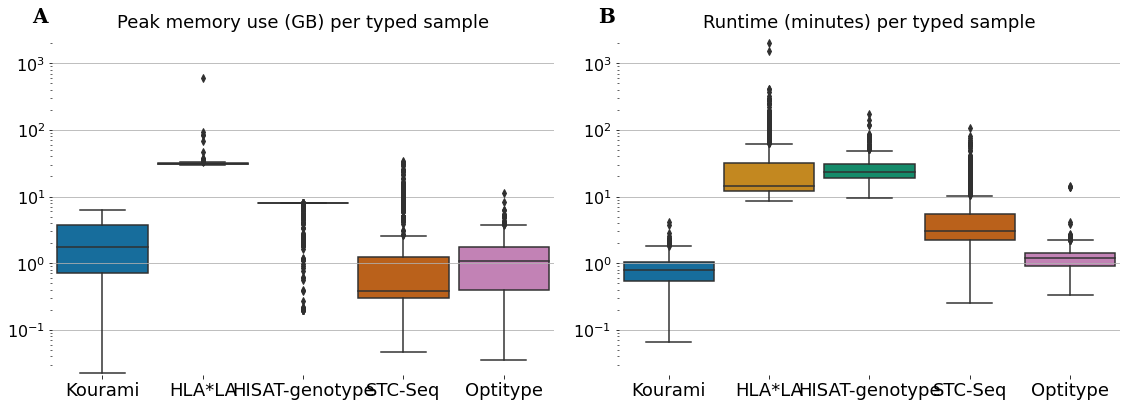

In [12]:
#Make dataframe wideformat
memory_use_wide_df = pd.melt(memory_use_gb_df, var_name='tool', value_name='memory_use_GB')

#Make dataframe wideformat
wall_time_min_wide_df = pd.melt(wall_time_min_df, var_name='tool', value_name='run_time_min')

# load data into a dataframe
fontsize = 16

# for i in range(2):
#     ax = axs[i]
#     if i == 0:
fig, axs = plt.subplot_mosaic([['A', 'B']], figsize=(16,6))
#figpanels = ['(A)', '(B)']

for label, ax in axs.items():

    if label == 'A':
        sns.boxplot('tool', 'memory_use_GB', data=memory_use_wide_df, ax = ax, palette=palette_list, width=0.9)
        ax.set_yscale('log')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.yaxis.grid()
        ax.set_ylim(min(memory_use_wide_df['memory_use_GB'])*0.95, max(wall_time_min_wide_df['run_time_min'])*1.4)

        #ax.set_xticklabels(['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-seq', 'Optitype'], size=fontsize)

        plt.rcParams.update({'font.size': fontsize+2})
        plt.rc('xtick', labelsize=fontsize+2)
        plt.rc('ytick', labelsize=fontsize+2)

        ax.set_title('Peak memory use (GB) per typed sample', size=18)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif', weight='bold')
             
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)   
        

    if label == 'B':
        sns.boxplot('tool', 'run_time_min', data=wall_time_min_wide_df, ax = ax, palette=palette_list, width=0.9)
        ax.set_yscale('log')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.yaxis.grid()
        ax.set_ylim(min(memory_use_wide_df['memory_use_GB'])*0.95, max(wall_time_min_wide_df['run_time_min'])*1.4)

        ax.set_title('Runtime (minutes) per typed sample', size=18)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif', weight='bold')
                
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)   


    ax.tick_params(axis="y", labelsize=16)

    
plt.tight_layout()
plt.show()

fig.savefig('plots/memory_time_usage.eps')

/home/nthu/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


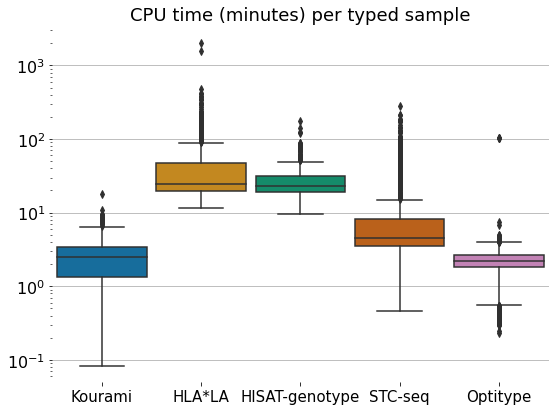

In [16]:
#Make dataframe wideformat
cpu_time_wide_df = pd.melt(cpu_time_min_df, var_name='tool', value_name='cpu_time_min')

# load data into a dataframe
fontsize = 14

# fig, axs = plt.subplots(1,2, figsize=(16,6))

# for i in range(2):
#     ax = axs[i]
#     if i == 0:
fig, axs = plt.subplot_mosaic([['(A)']], figsize=(8,6))

for label, ax in axs.items():

    sns.boxplot('tool', 'cpu_time_min', data=cpu_time_wide_df, ax = ax, palette=palette_list, width=0.9)
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.yaxis.grid()

    ax.set_xticklabels(['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-seq', 'Optitype'], size=fontsize)

    plt.rcParams.update({'font.size': fontsize+2})
    plt.rc('xtick', labelsize=fontsize+2)
    plt.rc('ytick', labelsize=fontsize+2)

    ax.set_title('CPU time (minutes) per typed sample', size=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)   

    ax.tick_params(axis="y", labelsize=16)
    ax.tick_params(axis="x", labelsize=15)

plt.tight_layout()
plt.show()

fig.savefig('plots/CPU_time_minutes.eps')